<a href="https://colab.research.google.com/github/eluyutao/MMAI-Deep-Learning-Projects/blob/main/NLP_Team_Assignment_Hybrid_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMAI 891 - TOPIC ANALYSIS - Hybrid Model with Pipeline


In [1]:
# # 891 specific additions
# from google.colab import drive
# drive.mount('/content/drive')
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split
# import seaborn as sns

In [2]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from matplotlib.pyplot import figure

In [3]:
pd.set_option("display.max_columns", 200)

In [4]:
# Load training data
url = "https://drive.google.com/file/d/1tGyKaXM5Z3xLCrQy-MeVK-11eAee82Ms/view"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10466 entries, 0 to 10465
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       10466 non-null  int64 
 1   message  10466 non-null  object
 2   label    10466 non-null  object
dtypes: int64(1), object(2)
memory usage: 245.4+ KB
None


,id,message,label
0,5396,I made a purchase recently but I have decided ...,request_refund
1,2202,"Cancel my transfer, please.",cancel_transfer
2,3768,How do I change my last name?,edit_personal_details
3,4967,A withdraw I tried to make at the ATM was decl...,declined_cash_withdrawal
4,5622,I tried to buy something online yesterday and ...,declined_transfer


# Preprocessing

In [5]:
!pip install unidecode
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
stop_words = set(stopwords.words('english'))
lemmer = WordNetLemmatizer()
def preprocess(x):
    x = x.lower()
    x = re.sub(r'[^\w\s]', '', x)
    x = unidecode.unidecode(x)
    x = re.sub(r'\d+', '', x)
    x = [lemmer.lemmatize(w) for w in x.split() if w not in stop_words]
    return ' '.join(x)

df['message_clean'] = df['message'].apply(preprocess)
df.head(2)

,id,message,label,message_clean
0,5396,I made a purchase recently but I have decided ...,request_refund,made purchase recently decided im buying need ...
1,2202,"Cancel my transfer, please.",cancel_transfer,cancel transfer please


In [7]:
# import nltk
# from nltk.util import ngrams
# from nltk.collocations import BigramCollocationFinder
# from nltk.metrics import BigramAssocMeasures
corpus = ' '.join(df.message_clean).split(' ')
word_fd = nltk.FreqDist(corpus)
bigram_fd = nltk.FreqDist(nltk.bigrams(corpus))
print(word_fd.most_common(50))
print(bigram_fd.most_common(50))

[('card', 3178), ('account', 1388), ('transfer', 1246), ('money', 1125), ('get', 845), ('payment', 836), ('need', 771), ('cash', 709), ('top', 657), ('exchange', 613), ('fee', 602), ('atm', 559), ('charged', 522), ('please', 508), ('app', 480), ('use', 471), ('transaction', 463), ('pending', 433), ('currency', 422), ('topup', 421), ('rate', 401), ('charge', 386), ('help', 378), ('pin', 374), ('still', 369), ('would', 364), ('long', 360), ('made', 358), ('new', 357), ('take', 354), ('didnt', 345), ('make', 341), ('dont', 322), ('withdrawal', 317), ('know', 315), ('want', 310), ('wrong', 310), ('im', 308), ('declined', 297), ('refund', 290), ('like', 284), ('one', 282), ('virtual', 280), ('time', 278), ('go', 271), ('tried', 269), ('got', 267), ('tell', 261), ('extra', 254), ('work', 254)]
[(('exchange', 'rate'), 354), (('virtual', 'card'), 270), (('card', 'payment'), 251), (('new', 'card'), 238), (('would', 'like'), 184), (('cash', 'withdrawal'), 179), (('disposable', 'card'), 130), (('

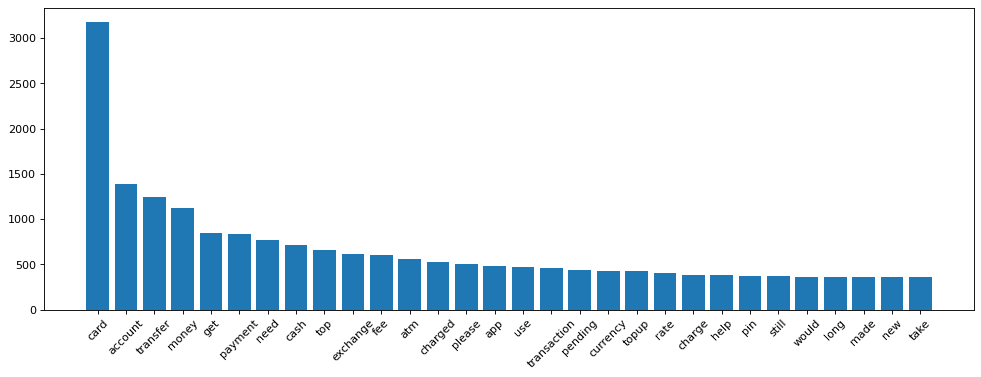

In [8]:
figure(figsize=(15, 5), dpi=80)
plt.bar([x[0] for x in word_fd.most_common(30)], [x[1] for x in word_fd.most_common(30)])
plt.xticks(rotation=45)
plt.show()

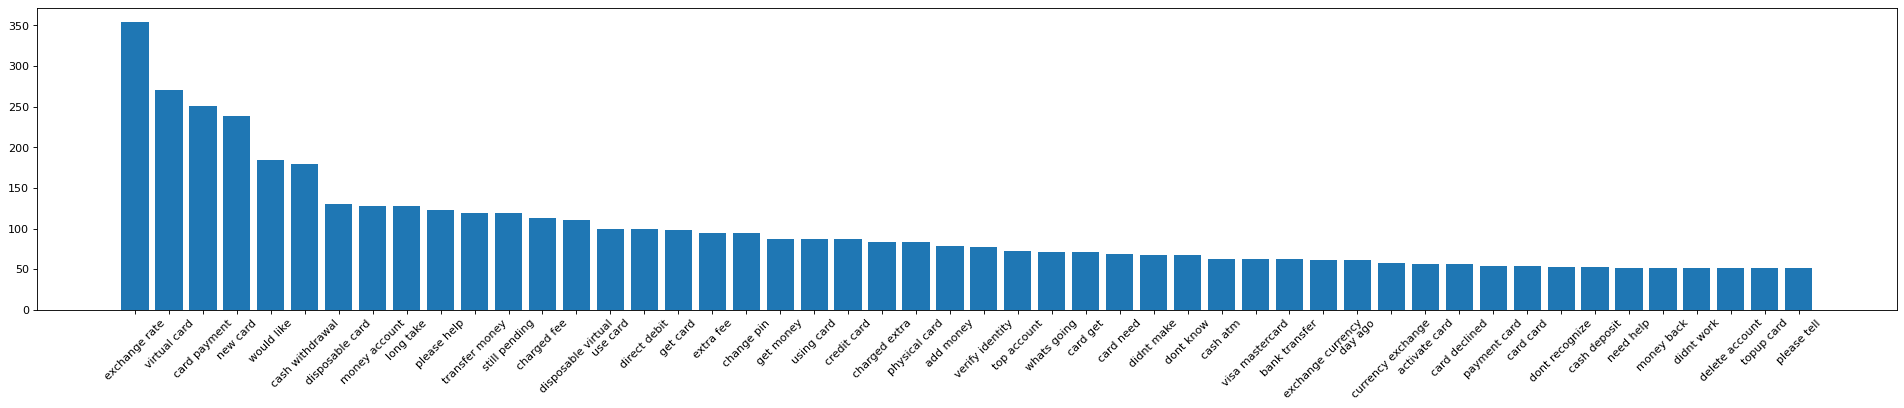

In [9]:
figure(figsize=(30, 5), dpi=80)
plt.bar([' '.join(x[0]) for x in bigram_fd.most_common(50)], [x[1] for x in bigram_fd.most_common(50)])
plt.xticks(rotation=45)
plt.show()

## CountVectorizer

In [10]:
count_vectorizer1 = CountVectorizer(analyzer='word', max_df=0.3, min_df=0.03, ngram_range=[1,1])
df_cnt = count_vectorizer1.fit_transform(df['message_clean'])
count_vectorizer1.get_feature_names_out()

array(['account', 'app', 'atm', 'card', 'cash', 'charge', 'charged',
       'currency', 'didnt', 'dont', 'exchange', 'fee', 'get', 'help',
       'long', 'made', 'make', 'money', 'need', 'new', 'payment',
       'pending', 'pin', 'please', 'rate', 'still', 'take', 'top',
       'topup', 'transaction', 'transfer', 'use', 'would'], dtype=object)

In [11]:
count_vectorizer2 = CountVectorizer(analyzer='word', max_df=0.5, min_df=0.01, ngram_range=[2,2])
df_cnt = count_vectorizer2.fit_transform(df['message_clean'])
count_vectorizer2.get_feature_names_out()

array(['card payment', 'cash withdrawal', 'charged fee',
       'disposable card', 'disposable virtual', 'exchange rate',
       'long take', 'money account', 'new card', 'please help',
       'still pending', 'transfer money', 'virtual card', 'would like'],
      dtype=object)

In [12]:
tmp_txt = 'able'
df_tmp = df.copy()
df_tmp.loc[df_tmp['message_clean'].str.contains(tmp_txt), f'contains_{tmp_txt}'] = 1
df_tmp.loc[~df_tmp['message_clean'].str.contains(tmp_txt), f'contains_{tmp_txt}'] = 0
print(df_tmp[f'contains_{tmp_txt}'].value_counts())
df_tmp[df_tmp[f'contains_{tmp_txt}']==1].label.value_counts()

0.0    9951
1.0     515
Name: contains_able, dtype: int64


disposable_card_limits              117
get_disposable_virtual_card          98
virtual_card_not_working             30
declined_cash_withdrawal             15
verify_source_of_funds               12
                                   ... 
getting_virtual_card                  1
card_payment_not_recognised           1
transfer_into_account                 1
card_payment_wrong_exchange_rate      1
atm_support                           1
Name: label, Length: 66, dtype: int64

In [13]:
df_cntv1 = pd.DataFrame(count_vectorizer1.fit_transform(df['message_clean']).toarray(), 
                      columns=count_vectorizer1.get_feature_names_out(), index=df.index)
df_cntv2 = pd.DataFrame(count_vectorizer2.fit_transform(df['message_clean']).toarray(), 
                      columns=count_vectorizer2.get_feature_names_out(), index=df.index)
df_cntv = pd.concat([df_cntv1, df_cntv2], axis=1).reset_index(drop=True)
print(df_cntv1.shape, df_cntv2.shape, df_cntv.shape)
df_cntv.head()

(10466, 33) (10466, 14) (10466, 47)


,account,app,atm,card,cash,charge,charged,currency,didnt,dont,exchange,fee,get,help,long,made,make,money,need,new,payment,pending,pin,please,rate,still,take,top,topup,transaction,transfer,use,would,card payment,cash withdrawal,charged fee,disposable card,disposable virtual,exchange rate,long take,money account,new card,please help,still pending,transfer money,virtual card,would like
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## TfidfVectorizer

In [14]:
vectorizer = TfidfVectorizer(max_df = 0.03, min_df = 0.01, max_features = 500, ngram_range=[1,3])
dtm = vectorizer.fit_transform(df['message_clean'])
print(dtm.shape)

(10466, 91)


In [15]:
# vectorizer.get_feature_names()

In [16]:
bow_df = pd.DataFrame(dtm.toarray(), columns=[f'{x}_f' for x in vectorizer.get_feature_names()], index=df.index)
bow_df = pd.concat([df, bow_df], axis=1)
print(bow_df.shape)

(10466, 95)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
bow_df.head(2)

,id,message,label,message_clean,able_f,add_f,ago_f,amount_f,back_f,balance_f,bank_f,bought_f,cancel_f,cant_f,card payment_f,cash withdrawal_f,change_f,charged fee_f,check_f,cheque_f,come_f,could_f,country_f,day_f,debit_f,declined_f,deposit_f,disposable_f,disposable card_f,disposable virtual_f,disposable virtual card_f,extra_f,find_f,fund_f,getting_f,go_f,going_f,got_f,hasnt_f,identity_f,im_f,isnt_f,ive_f,keep_f,know_f,like_f,limit_f,long take_f,lost_f,mastercard_f,money account_f,much_f,new card_f,one_f,order_f,pay_f,phone_f,please help_f,possible_f,purchase_f,reason_f,receive_f,received_f,refund_f,see_f,sent_f,show_f,showing_f,someone_f,something_f,statement_f,still pending_f,tell_f,think_f,time_f,today_f,transfer money_f,tried_f,used_f,using_f,verification_f,verify_f,virtual_f,virtual card_f,visa_f,want_f,week_f,whats_f,withdraw_f,withdrawal_f,work_f,working_f,would like_f,wrong_f,yet_f
0,5396,I made a purchase recently but I have decided ...,request_refund,made purchase recently decided im buying need ...,0.0,0.0,0.0,0.0,0.462195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.41428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.464916,0.0,0.47361,0.0,0.417485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2202,"Cancel my transfer, please.",cancel_transfer,cancel transfer please,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Sentence Embedding using Universal Sentence Encoder

In [18]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [19]:
embed_f = embed(df.message).numpy()
print(embed_f.shape)
embed_df = pd.DataFrame(embed_f)

(10466, 512)


## Combine all features

In [20]:
df_all = pd.concat([bow_df, embed_df, df_cntv], axis = 1).reset_index(drop=True)
df_all.shape

(10466, 654)

In [21]:
df_all.head(2)

,id,message,label,message_clean,able_f,add_f,ago_f,amount_f,back_f,balance_f,bank_f,bought_f,cancel_f,cant_f,card payment_f,cash withdrawal_f,change_f,charged fee_f,check_f,cheque_f,come_f,could_f,country_f,day_f,debit_f,declined_f,deposit_f,disposable_f,disposable card_f,disposable virtual_f,disposable virtual card_f,extra_f,find_f,fund_f,getting_f,go_f,going_f,got_f,hasnt_f,identity_f,im_f,isnt_f,ive_f,keep_f,know_f,like_f,limit_f,long take_f,lost_f,mastercard_f,money account_f,much_f,new card_f,one_f,order_f,pay_f,phone_f,please help_f,possible_f,purchase_f,reason_f,receive_f,received_f,refund_f,see_f,sent_f,show_f,showing_f,someone_f,something_f,statement_f,still pending_f,tell_f,think_f,time_f,today_f,transfer money_f,tried_f,used_f,using_f,verification_f,verify_f,virtual_f,virtual card_f,visa_f,want_f,week_f,whats_f,withdraw_f,withdrawal_f,work_f,working_f,would like_f,wrong_f,yet_f,0,1,2,3,4,...,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,account,app,atm,card,cash,charge,charged,currency,didnt,dont,exchange,fee,get,help,long,made,make,money,need,new,payment,pending,pin,please,rate,still,take,top,topup,transaction,transfer,use,would,card payment,cash withdrawal,charged fee,disposable card,disposable virtual,exchange rate,long take,money account,new card,please help,still pending,transfer money,virtual card,would like
0,5396,I made a purchase recently but I have decided ...,request_refund,made purchase recently decided im buying need ...,0.0,0.0,0.0,0.0,0.462195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.41428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.464916,0.0,0.47361,0.0,0.417485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.061729,-0.068649,0.038512,0.042635,0.057322,...,-0.042800,0.070503,-0.028549,0.049850,-0.103668,0.020154,0.02994,0.047143,-0.003286,0.018077,0.086932,-0.034706,-0.043466,0.030217,-0.042564,0.051074,-0.050893,0.079563,0.019964,0.001450,-0.019675,0.009427,-0.041669,0.045783,-0.061476,0.025630,0.034514,0.003584,0.065953,-0.000431,-0.044748,0.091268,-0.000449,-0.015103,0.037511,0.077155,-0.035467,0.035280,-0.026301,-0.051213,-0.054744,-0.019299,0.005445,-0.085266,0.062792,0.025089,-0.018941,-0.017366,-0.042966,0.044959,-0.010827,-0.030065,0.005671,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2202,"Cancel my transfer, please.",cancel_transfer,cancel transfer please,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026600,-0.055421,0.003102,0.006975,0.064788,...,-0.004716,0.022753,-0.008813,-0.048323,-0.078936,0.028831,0.00783,-0.001577,-0.028811,0.003606,0.064856,-0.035331,0.008973,-0.035022,0.012001,0.064268,-0.075422,-0.059974,-0.005675,-0.010846,0.060703,-0.033841,0.054151,0.064514,-0.001107,0.010933,-0.027007,0.022682,-0.004977,0.012928,-0.032069,0.029145,0.009165,0.042480,0.050433,0.079688,0.045961,0.093172,-0.076623,0.045490,-0.076176,0.043851,-0.047960,-0.018478,-0.020918,0.047711,-0.031146,-0.040816,0.077443,0.002419,-0.032232,-0.039207,-0.035347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Train/Validation SPLIT, PIPELINE 

In [22]:
df_all.drop(labels=['id','message','message_clean'], inplace=True, axis=1)

In [23]:
df_all.head(2)

,label,able_f,add_f,ago_f,amount_f,back_f,balance_f,bank_f,bought_f,cancel_f,cant_f,card payment_f,cash withdrawal_f,change_f,charged fee_f,check_f,cheque_f,come_f,could_f,country_f,day_f,debit_f,declined_f,deposit_f,disposable_f,disposable card_f,disposable virtual_f,disposable virtual card_f,extra_f,find_f,fund_f,getting_f,go_f,going_f,got_f,hasnt_f,identity_f,im_f,isnt_f,ive_f,keep_f,know_f,like_f,limit_f,long take_f,lost_f,mastercard_f,money account_f,much_f,new card_f,one_f,order_f,pay_f,phone_f,please help_f,possible_f,purchase_f,reason_f,receive_f,received_f,refund_f,see_f,sent_f,show_f,showing_f,someone_f,something_f,statement_f,still pending_f,tell_f,think_f,time_f,today_f,transfer money_f,tried_f,used_f,using_f,verification_f,verify_f,virtual_f,virtual card_f,visa_f,want_f,week_f,whats_f,withdraw_f,withdrawal_f,work_f,working_f,would like_f,wrong_f,yet_f,0,1,2,3,4,5,6,7,...,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,account,app,atm,card,cash,charge,charged,currency,didnt,dont,exchange,fee,get,help,long,made,make,money,need,new,payment,pending,pin,please,rate,still,take,top,topup,transaction,transfer,use,would,card payment,cash withdrawal,charged fee,disposable card,disposable virtual,exchange rate,long take,money account,new card,please help,still pending,transfer money,virtual card,would like
0,request_refund,0.0,0.0,0.0,0.0,0.462195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.41428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.464916,0.0,0.47361,0.0,0.417485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.061729,-0.068649,0.038512,0.042635,0.057322,0.005878,0.021205,-0.026813,...,-0.042800,0.070502,-0.028549,0.049850,-0.103668,0.020154,0.02994,0.047143,-0.003286,0.018077,0.086932,-0.034706,-0.043466,0.030217,-0.042564,0.051074,-0.050893,0.079563,0.019964,0.001450,-0.019675,0.009427,-0.041669,0.045783,-0.061476,0.025629,0.034514,0.003584,0.065953,-0.000431,-0.044748,0.091268,-0.000449,-0.015103,0.037511,0.077155,-0.035467,0.035280,-0.026301,-0.051213,-0.054744,-0.019299,0.005445,-0.085266,0.062792,0.025089,-0.018941,-0.017366,-0.042966,0.044959,-0.010827,-0.030065,0.005671,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,cancel_transfer,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026600,-0.055421,0.003102,0.006975,0.064788,-0.010183,0.040920,-0.051453,...,-0.004716,0.022753,-0.008813,-0.048323,-0.078936,0.028831,0.00783,-0.001577,-0.028811,0.003606,0.064856,-0.035331,0.008973,-0.035022,0.012001,0.064268,-0.075422,-0.059974,-0.005675,-0.010846,0.060703,-0.033841,0.054151,0.064514,-0.001107,0.010933,-0.027007,0.022682,-0.004977,0.012928,-0.032069,0.029145,0.009165,0.042480,0.050433,0.079688,0.045961,0.093172,-0.076623,0.045490,-0.076176,0.043851,-0.047960,-0.018478,-0.020918,0.047711,-0.031146,-0.040816,0.077443,0.002419,-0.032232,-0.039207,-0.035347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [337]:
x = set()
for item in df_all.columns:
  if item in x:
    print('duplicates: ', item)
  else:
    x.add(item)

In [338]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

y = df_all['label']
y = LabelEncoder().fit_transform(y)

X = df_all.drop(['label'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [339]:
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import metrics

In [348]:
pipe = Pipeline(steps=[('xgb', XGBClassifier())])
search_space = \
     {"xgb__n_estimators": [100, 500, 800],
      "xgb__criterion": ["gini", "entropy"],
      "xgb__max_leaf_nodes": [100, 300],
      "xgb__random_state": [22],
      "xgb__max_depth": [2,4],
      "xgb__learning_rate": [0.05, 0.1, 0.15],
      "xgb__tree_method": ["gpu_hist"]}

search_space = \
     {"xgb__learning_rate": [0.1],
      "xgb__tree_method": ["gpu_hist"]}

kfold = StratifiedKFold(n_splits=3,
                        random_state=22, shuffle=True)

grid = GridSearchCV(estimator=pipe, 
                    param_grid=search_space,
                    cv=kfold,
                    scoring='accuracy',  # Accuracy
                    return_train_score=True,
                    n_jobs=-1,
                    verbose=2) 

In [349]:
%%time
best_model = grid.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 41.3 s, sys: 533 ms, total: 41.8 s
Wall time: 2min 51s


In [342]:
best_model.cv_results_

{'mean_fit_time': array([172.4982841 , 170.46894701, 118.02393643]),
 'mean_score_time': array([0.4604369 , 0.43902795, 0.32523259]),
 'mean_test_score': array([0.80155054, 0.82163039, 0.81607558]),
 'mean_train_score': array([0.99839268, 1.        , 1.        ]),
 'param_xgb__learning_rate': masked_array(data=[0.05, 0.1, 0.2],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_xgb__tree_method': masked_array(data=['gpu_hist', 'gpu_hist', 'gpu_hist'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'xgb__learning_rate': 0.05, 'xgb__tree_method': 'gpu_hist'},
  {'xgb__learning_rate': 0.1, 'xgb__tree_method': 'gpu_hist'},
  {'xgb__learning_rate': 0.2, 'xgb__tree_method': 'gpu_hist'}],
 'rank_test_score': array([3, 1, 2], dtype=int32),
 'split0_test_score': array([0.8013471 , 0.82221382, 0.82022969]),
 'split0_train_score': array([0.99919867, 1.        , 1.        ]),
 'split1_tes

In [350]:
print(best_model.best_params_)
best_model.cv_results_['mean_test_score'].max()

{'xgb__learning_rate': 0.1, 'xgb__tree_method': 'gpu_hist'}


0.849662307573355

In [351]:
y_pred = best_model.predict(X_test)

In [352]:
metrics.adjusted_mutual_info_score(y_test,y_pred)

0.8296579834484429

## Hyperparameter Tuning using Optuna

In [ ]:
# !pip install optuna
!pip install git+https://github.com/optuna/optuna.git

In [23]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

In [24]:
def objective(trial):
    y = df_all['label']
    y = LabelEncoder().fit_transform(y)
    X = df_all.drop(['label'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)


    param = {
        # "silent": 1,
        "objective": "multi:softmax",
        "num_class": len(set(y_train)),
        "eval_metric": "mlogloss",
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000),
        "max_leaf_nodes": trial.suggest_int("max_depth", 100, 1000),
        "random_state": 22
        # "tree_method": "gpu_hist"
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0) # learning rate
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-mlogloss")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)
    ami = metrics.adjusted_mutual_info_score(y_test, pred_labels)
    return ami

In [ ]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=60*60*3, gc_after_trial=True)

[I 2022-04-10 01:04:19,391] A new study created in memory with name: no-name-aefa5b6f-2b86-43a2-9ae8-e96bf88f54f6
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:657: RuntimeWarning: Inconsistent parameter values for distribution with name "max_depth"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsis

[0]	validation-mlogloss:4.34126
[1]	validation-mlogloss:4.33872
[2]	validation-mlogloss:4.33615
[3]	validation-mlogloss:4.33366
[4]	validation-mlogloss:4.33109
[5]	validation-mlogloss:4.3285
[6]	validation-mlogloss:4.32603
[7]	validation-mlogloss:4.32344
[8]	validation-mlogloss:4.32091
[9]	validation-mlogloss:4.31843


[I 2022-04-10 01:07:46,650] Trial 0 finished with value: 0.572708918203658 and parameters: {'booster': 'dart', 'lambda': 1.0983221621816874e-06, 'alpha': 5.87785119134173e-06, 'max_depth': 971, 'eta': 0.0001429209168865925, 'gamma': 1.7870918783790934e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0004499626965717082, 'skip_drop': 4.440359643195142e-06}. Best is trial 0 with value: 0.572708918203658.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tria

[0]	validation-mlogloss:4.3438
[1]	validation-mlogloss:4.3438
[2]	validation-mlogloss:4.3438
[3]	validation-mlogloss:4.3438
[4]	validation-mlogloss:4.3438
[5]	validation-mlogloss:4.3438
[6]	validation-mlogloss:4.3438
[7]	validation-mlogloss:4.3438
[8]	validation-mlogloss:4.3438
[9]	validation-mlogloss:4.3438


[I 2022-04-10 01:11:01,177] Trial 1 finished with value: 0.5669802362062802 and parameters: {'booster': 'gbtree', 'lambda': 1.2907526367626069e-07, 'alpha': 0.04452891132472052, 'max_depth': 823, 'eta': 2.3457981212658912e-08, 'gamma': 0.46023041422162714, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.572708918203658.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:657: RuntimeWarning: Inconsistent param

[0]	validation-mlogloss:4.3438
[1]	validation-mlogloss:4.3438
[2]	validation-mlogloss:4.3438
[3]	validation-mlogloss:4.3438
[4]	validation-mlogloss:4.3438
[5]	validation-mlogloss:4.3438
[6]	validation-mlogloss:4.3438
[7]	validation-mlogloss:4.3438
[8]	validation-mlogloss:4.3438
